In [2]:
import bpy
from IPython.display import display, Image

def fresh_scene():
    # Deselect all objects
    bpy.ops.object.select_all(action='DESELECT')
    # Select all objects except cameras
    for obj in bpy.context.scene.objects:
        if  obj.type != 'CAMERA':
            obj.select_set(True)
        else:
            obj.select_set(False)
    bpy.ops.object.delete()
    
    # add light
    bpy.ops.object.light_add(type='SUN')
    sun = bpy.context.object

    sun.location = (0, 0, 0)
    from math import radians
    sun.rotation_euler = (radians(204), radians(-133), radians(-67))
    sun.data.energy = 5  


def render_result():
    bpy.ops.render.render()
    bpy.data.images['Render Result'].save_render(filepath="img.png")
    display(Image(filename="img.png"))


In [3]:
import pandas as pd
url = 'https://raw.githubusercontent.com/kolibril13/ipydrop/refs/heads/main/dino.csv'
df = pd.read_csv(url)
length_data = len(df)
print(f"Loaded {length_data} rows")
df.head()

Loaded 142 rows


,x,y
0,55.3846,97.1795
1,51.5385,96.0256
2,46.1538,94.4872
3,42.8205,91.4103
4,40.7692,88.3333


In [4]:
import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')

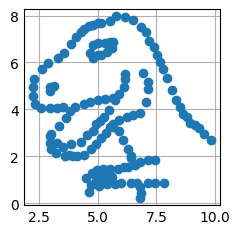

In [5]:
# Extract x and y from the DataFrame
x_values = df['x'] / 10 
y_values = df['y'] / 10 * 0.8

# Create the scatter plot using plt.scatter
plt.axis('equal');
plt.scatter(x_values, y_values);

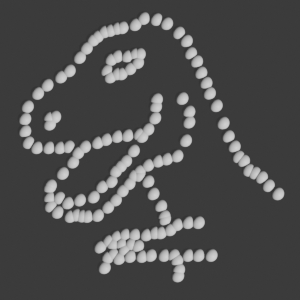

In [6]:
fresh_scene()



for (x, y) in zip(x_values,y_values):    
    bpy.ops.mesh.primitive_uv_sphere_add(radius=0.2, location=(x, y, 0))

camera = bpy.context.scene.camera
camera.location = (6, 4, 10)  # Position above the XY plane
camera.rotation_euler = (0, 0, 0)  # Rotate to look at XY plane
# Set the camera to orthographic mode
camera.data.type = 'ORTHO'
# Set the orthographic scale to 12
camera.data.ortho_scale = 9

bpy.context.scene.render.resolution_x = 300
bpy.context.scene.render.resolution_y = 300

render_result()

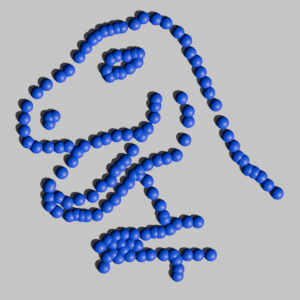

In [7]:
fresh_scene()

mat = bpy.data.materials.new(name="GreenMaterial")
mat.diffuse_color = (0, 0, 1, 1)  # Green color (R, G, B, A)

for (x, y) in zip(x_values,y_values):    
    bpy.ops.mesh.primitive_uv_sphere_add(radius=0.2, location=(x, y, 0))
    bpy.context.active_object.data.materials.append(mat)

bpy.context.scene.render.resolution_x = 300
bpy.context.scene.render.resolution_y = 300

# Add a white plane behind the spheres
bpy.ops.mesh.primitive_plane_add(size=20, location=(5, 5, 0))  
plane = bpy.context.active_object

# Create a white material and assign it to the plane
white_mat = bpy.data.materials.new(name="WhiteMaterial")
white_mat.diffuse_color = (1, 1, 1, 1)  # White color (R, G, B, A)
plane.data.materials.append(white_mat)

render_result()

this works, but it's very limited!
E.g. 
* not possible to scale individual spheres.
* not possible to use geometry nodes with this object.

Can we maybe add this geometry nodes setup?

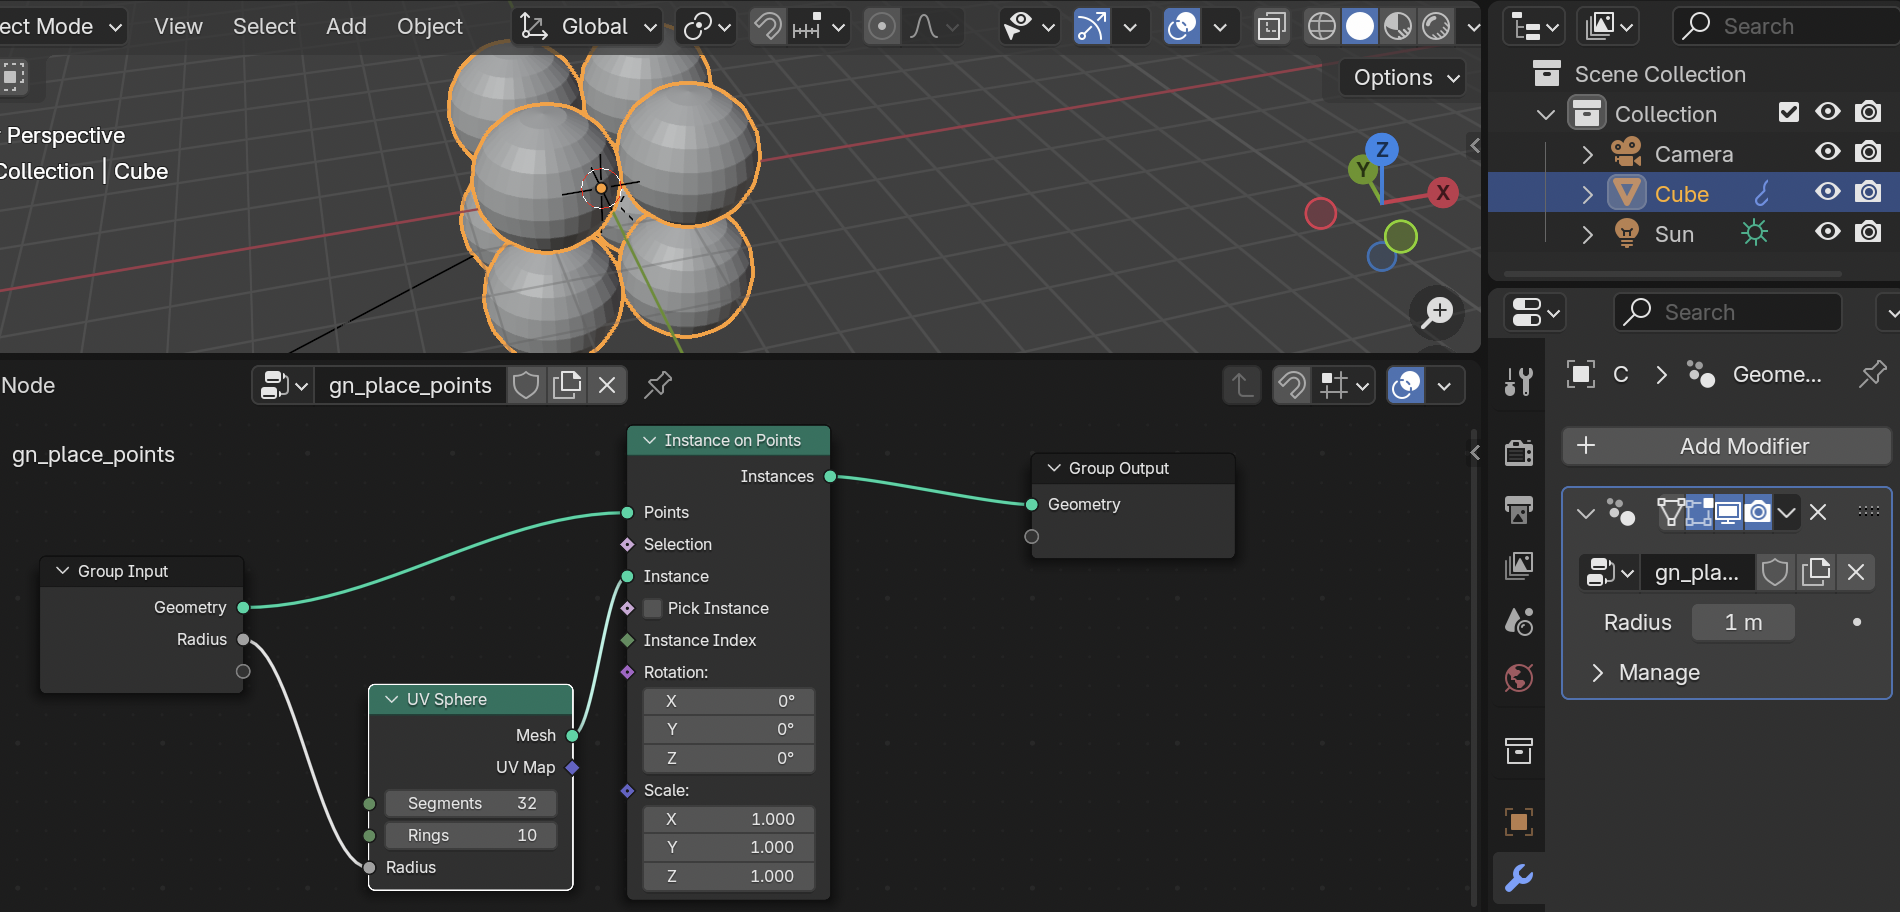

In [23]:
bpy.ops.wm.open_mainfile(filepath="cube_with_place_points.blend")

# Access the node group
node_group_place_points = bpy.data.node_groups["gn_place_points"]

# Print all the node names inside the node group
print("Nodes in node group 'gn_place_points':")
for node in node_group_place_points.nodes:
    print(node.name)

Read blend: "/Users/jan-hendrik/projects/ipyblender-experimental/cube_with_place_points.blend"
Nodes in node group 'gn_place_points':
Group Input
Group Output
Instance on Points
UV Sphere


In [ ]:
modifier = graph.modifiers.new(name="GeometryNodes", type='NODES')
modifier.node_group = bpy.data.node_groups["default_node"]

In [ ]:
    raindrop_node_group = bpy.data.node_groups['add_raindrops']


In [27]:
length_data

142

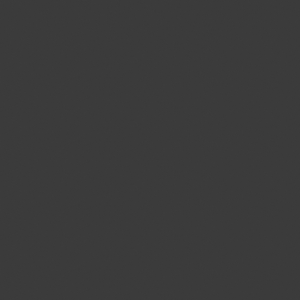

In [34]:
fresh_scene()
import mathutils

mesh = bpy.data.meshes.new("PointCloud")
point_cloud_object = bpy.data.objects.new("PointCloudObject", mesh)
bpy.context.collection.objects.link(point_cloud_object)

points = [mathutils.Vector((0, 0, 0)) for i in range(length_data)]

mesh.from_pydata(points, [], [])
mesh.update()

render_result()

In [35]:
len(point_cloud_object.data.vertices)

142

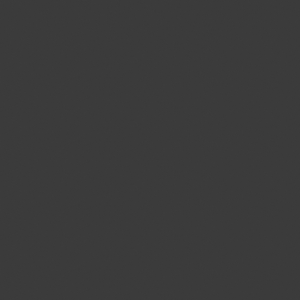

: 

In [37]:
# Use zip to iterate over the vertices and the new x and y values simultaneously
for vertex, x, y in zip(point_cloud_object.data.vertices, x_values, y_values):
    vertex.co.x = x
    vertex.co.y = y
    vertex.co.z = 0  # Set z as 0, modify if z-values are available

# Update the mesh after modifying vertices
point_cloud_object.data.update()

render_result()